In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision.models as models
from torchvision import models, datasets, transforms, utils
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import gc
import time
import copy
import os
import sys
import tqdm
from PIL import Image
import json
import requests
from collections import OrderedDict
from efficientnet_pytorch import EfficientNet
from grad_cam import GradCam, GuidedBackpropReLUModel, show_cams, show_gbs, preprocess_image
import ttach as tta
import shap


In [2]:
# Define transformations for the training data and validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='train', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_ftrs, 2)

resnet18 = resnet18.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Using device: cuda


/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Train the model
num_epochs = 2
best_model_wts = copy.deepcopy(resnet18.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet18.train()  
            dataloader = train_loader
        else:
            resnet18.eval()   
            dataloader = val_loader
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet18(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize 
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(resnet18.state_dict())

    print()

print('Training complete')
print(f'Best val Acc: {best_acc:4f}')

# Save the best model weights 
torch.save(best_model_wts, 'best_model_weights_resnet18.pth')

Epoch 1/2
----------
train Loss: 0.0751 Acc: 0.9709
val Loss: 0.0370 Acc: 0.9864

Epoch 2/2
----------
train Loss: 0.0314 Acc: 0.9893
val Loss: 0.0317 Acc: 0.9878

Training complete
Best val Acc: 0.987800


## Gradcam

In [21]:
# Load the best model weights 
best_model_wts = torch.load('best_model_weights_resnet18.pth')

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_ftrs, 2)

resnet18.load_state_dict(best_model_wts)
model = resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    inputs = preprocessed_img.requires_grad_(True)
    return inputs


grad_cam = GradCam(model=model, blob_name='layer4', target_layer_names=['1'], use_cuda=device.type == 'cuda')

img = cv2.imread('./test1/2.jpg', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img).to(device)  

inputs.retain_grad()

target_index = 1

mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name='ReLU', use_cuda=device.type == 'cuda')
show_gbs(inputs, gb_model, target_index, mask_dic)

/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LIME

/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

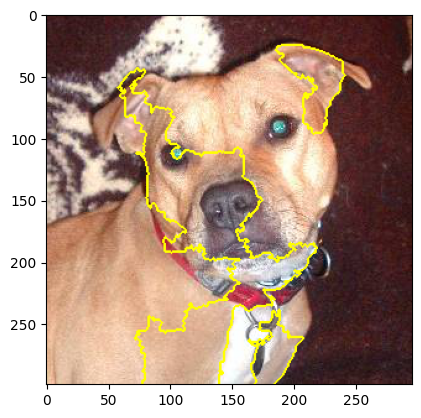

In [15]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load your custom trained ResNet18 model
best_model_wts = torch.load('best_model_weights_resnet18.pth')

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_ftrs, 2)
resnet18.load_state_dict(best_model_wts)

model = resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path)
    return preprocess(image).unsqueeze(0)

# Load and preprocess the image
image_path = './test1/2.jpg'
input_image = load_image(image_path)

def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(i)) for i in images], dim=0)
    batch = batch.to(device)
    
    with torch.no_grad():
        logits = model(batch)
    
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(np.array(Image.open(image_path)),
                                         batch_predict, 
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

top_label = explanation.top_labels[1]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=10, hide_rest=False)

plt.imshow(mark_boundaries(np.array(Image.open(image_path)), mask))
plt.show()


## SHAP

In [19]:
# Load your custom trained ResNet18 model
best_model_wts = torch.load('best_model_weights_resnet18.pth')

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_ftrs, 2)
resnet18.load_state_dict(best_model_wts)

model = resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path)
    return preprocess(image).unsqueeze(0)

# Load and preprocess the image
image_path = './test1/2.jpg'
input_image = load_image(image_path).to(device)

def predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(np.uint8(img))) for img in images], dim=0)
    batch = batch.to(device)
    
    with torch.no_grad():
        logits = model(batch)
    
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    
masker = shap.maskers.Image("inpaint_telea", (448, 448, 3))

explainer = shap.Explainer(predict, masker)

image = Image.open(image_path).resize((448, 448))
input_image = np.array(image)

shap_values = explainer(np.array([input_image]))

shap.image_plot(shap_values, np.array([input_image]))

/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "features.0.weight", "features.0.bias", "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.16.weight", "features.16.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.23.weight", "features.23.bias", "features.25.weight", "features.25.bias", "features.28.weight", "features.28.bias", "features.30.weight", "features.30.bias", "features.32.weight", "features.32.bias", "features.34.weight", "features.34.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 